# Task 4 Explorative Data Analysis
## Group 03
04 January 2019

In [1]:
import time
print(time.asctime())

Wed Jan  9 13:56:34 2019


In [2]:
import sys
print(sys.version)

3.6.7 |Anaconda, Inc.| (default, Oct 28 2018, 19:44:12) [MSC v.1915 64 bit (AMD64)]


In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as st
import glob
import os
import matplotlib.pyplot as plt

import warnings
import statsmodels as sm
import matplotlib
from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
# so we don't have to do plt.show() every time
%matplotlib inline
sns.set_style("ticks")

## Comparison of results to ground truth

In [5]:
A1_complete = pd.read_csv("2017_LSC_A1.csv")
A2_complete = pd.read_csv("2017_LSC_A2.csv")
A1_truth = pd.read_csv("2017_LSC_A1_truth.csv", names=["image_ID", "ground_truth"], header=None)
A2_truth = pd.read_csv("2017_LSC_A2_truth.csv", names=["image_ID", "ground_truth"], header=None)

# get pure plant_ID
for df in [A1_complete, A2_complete, A1_truth, A2_truth]:
    df['image_ID'] = df['image_ID'].str.split('_').str[0]

# get number of leaves
A1_results = A1_complete.groupby("image_ID").size().to_frame(name = 'count').reset_index().set_index("image_ID")
A2_results = A2_complete.groupby("image_ID").size().to_frame(name = 'count').reset_index().set_index("image_ID")
A1_truth.set_index("image_ID", inplace=True)
A2_truth.set_index("image_ID", inplace=True)

A1_counts = pd.concat([A1_results, A1_truth], axis=1, sort=True)
A2_counts = pd.concat([A2_results, A2_truth], axis=1, sort=True)

# replace NaN with 0, plant was lost because leaves were to small for particle analyzer
A2_counts = A2_counts.fillna(0)

Root mean sqaured error is  6.722745904762428


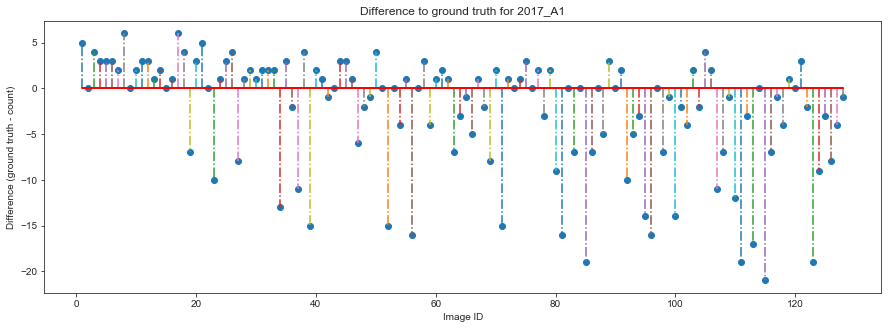

In [6]:
values = (A1_counts["ground_truth"] - A1_counts["count"])**2
print("Root mean sqaured error is ", sqrt(values.mean()))

plt.rcParams["figure.figsize"] = [15,5]
markerline, stemlines, baseline = plt.stem(range(1,A1_counts.shape[0]+1), A1_counts["ground_truth"] - A1_counts["count"], linefmt='-.')
plt.setp(baseline, color='r', linewidth=2)
plt.title('Difference to ground truth for 2017_A1')
plt.ylabel('Difference (ground truth - count)')
plt.xlabel('Image ID')
plt.savefig("A1-truth.png")

Root mean sqaured error is  2.747432819337753


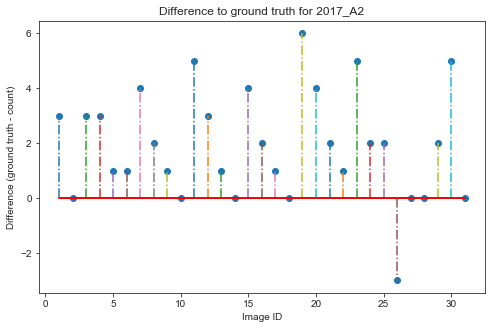

In [7]:
values = (A2_counts["ground_truth"] - A2_counts["count"])**2
print("Root mean sqaured error is ", sqrt(values.mean()))

plt.rcParams["figure.figsize"] = [8,5]
markerline, stemlines, baseline = plt.stem(range(1,A2_counts.shape[0]+1), A2_counts["ground_truth"] - A2_counts["count"], linefmt='-.')
plt.setp(baseline, color='r', linewidth=2)
plt.title('Difference to ground truth for 2017_A2')
plt.ylabel('Difference (ground truth - count)')
plt.xlabel('Image ID')
plt.savefig("A2-truth.png")

Our results for the A1 dataset show a huge variation from the ground truth. The root mean squared error for this dataset is 6.72. In comparison, we can observe a lower deviation from the ground truth for the A2 dataset. Here, the root mean squared error is 2.75. 

By visual considerations of both datasets, we observed a number of mossy plants in the A1 dataset. For classification of plant and background, a Trained Weka Segmentation classifier was used. This classifier was manually trained with traces from background and plant. Since moss is green as well, it was not possible to train the classifier so that it can distinguish moss from plant. Therefore, the huge deviation in results for the A1 datasets can be explained with the bad performance of the classifier in terms of mossy plant pots.

## Analysis of 2017 A2 datasets
Since the previous analysis showed that the classifier performed not well on the A1 dataset, the following analyses are only conducted on the A2 dataset.

In [8]:
df_complete = pd.read_csv("2017_LSC_A2.csv")
df = df_complete[["image_ID", "size", "roundness", "brightness_average_green","feret_ratio", "width_to_height_ratio"]]
df.head()

,image_ID,size,roundness,brightness_average_green,feret_ratio,width_to_height_ratio
0,plant001_rgb_class_watershed,155,0.807,158.909677,0.788932,1.000000
1,plant001_rgb_class_watershed,161,0.735,159.012422,0.730091,0.875000
2,plant002_rgb_class_watershed,361,0.873,167.720222,0.828233,0.954545
3,plant002_rgb_class_watershed,212,0.934,160.108491,0.871576,1.062500
4,plant002_rgb_class_watershed,225,0.957,165.986667,0.925839,1.000000


### Overview

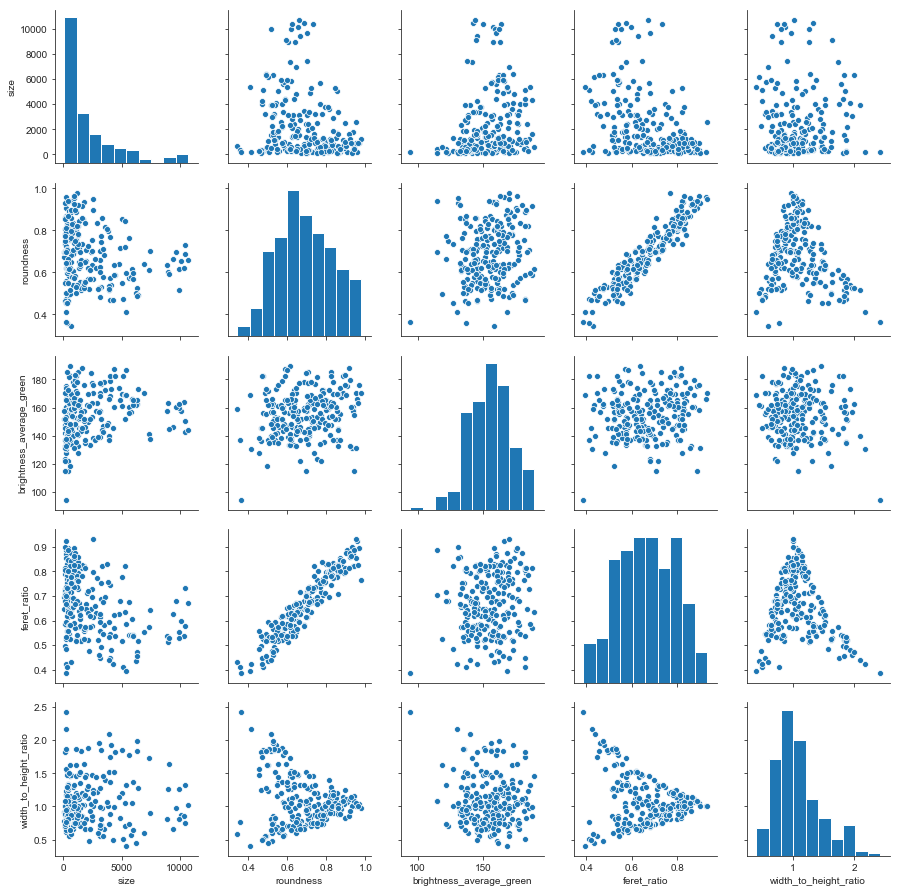

In [9]:
pairplot = sns.pairplot(df)
fig = pairplot.fig
fig.savefig("overview.png") 

The seaborn pairplot function is used to get an overview of the data. From this overview, a positive correlation between feret-ration and roundness can be observed.

In [10]:
st.pearsonr(df["roundness"], df["feret_ratio"])

(0.9449179681804596, 4.118674149562882e-111)

The pearson corelation coefficient is 0.94 with $p < 0.5$, which demonstrates that roundness and feret ratio are highly significantly corelated.

### Does the size of a leaf relate to its roundness?

C:\Users\regin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\regin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


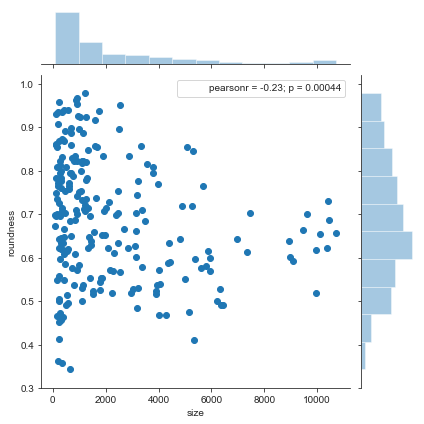

In [11]:
g = sns.JointGrid(x="size", y="roundness", data=df[["size","roundness"]])
g = g.plot_joint(plt.scatter)
g = g.plot_marginals(sns.distplot, kde=False)
g = g.annotate(st.pearsonr)
fig = g.fig
fig.savefig("size-roundness.png")

No, the size of a leaf is not correlated to its roundness. The Pearson correlation coefficient for this dataset is -0.23. 


### Does the size of a leaf relate to its color?

C:\Users\regin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


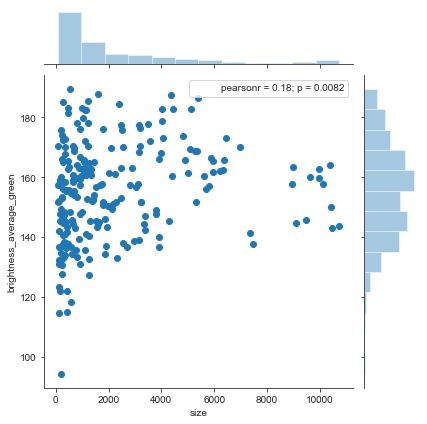

In [12]:
g = sns.JointGrid(x="size", y="brightness_average_green", data=df[["size","brightness_average_green"]])
g = g.plot_joint(plt.scatter)
g = g.plot_marginals(sns.distplot, kde=False)
g = g.annotate(st.pearsonr)
fig = g.fig
fig.savefig("size-color.png")

The size of a leaf is not correlated to the average brightness of the green channel. The Pearson correlation coefficient is 0.58

### Is the number of leaves per plant correlated to the total leaf area?

In [13]:
# number of objects for each image_ID
number = df.groupby("image_ID").size()

# sum of size of objects for each image_ID
area = df.groupby("image_ID")["size"].agg("sum")

number_area = number.to_frame().join(area.to_frame())
number_area.rename(columns={number_area.columns[0] : "num_leaves"}, inplace=True)

C:\Users\regin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


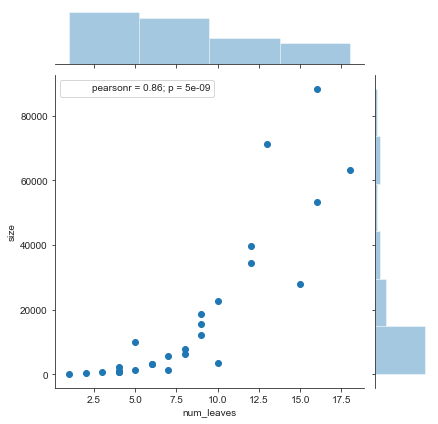

SpearmanrResult(correlation=0.9432544019967781, pvalue=5.831099082653899e-14)


In [14]:
g = sns.JointGrid(x="num_leaves", y="size", data=number_area)
g = g.plot_joint(plt.scatter)
g = g.plot_marginals(sns.distplot, kde=False)
g = g.annotate(st.pearsonr)
fig = g.fig
fig.savefig("number-area.png")
plt.show()

spear_corr = st.spearmanr(number_area["num_leaves"], number_area["size"])
print(spear_corr)

The number of leaves is correlated to the total leaf area. The Pearson correlation coefficient is 0.86, and the Spearman Rank Coefficient is approximately 0.94. The Pearson correlation coefficient only captures linear relationships, whereas the Spearman coefficient can measure non-linear correlations. In our case, the Spearman coefficient seems to better describe the relationship.

## Comparison of A1 and A2 datasets

In [15]:
# Dataframes for 2014 A1 data and 2014 A2 data
A1_complete = pd.read_csv("2017_LSC_A1.csv")
A2_complete = pd.read_csv("2017_LSC_A2.csv")

A1 = A1_complete[["image_ID", "size", "roundness", "brightness_average_green","feret_ratio", "width_to_height_ratio"]]
A2 = A2_complete[["image_ID", "size", "roundness", "brightness_average_green","feret_ratio", "width_to_height_ratio"]]

In [16]:
A1.head()

,image_ID,size,roundness,brightness_average_green,feret_ratio,width_to_height_ratio
0,plant001_rgb_class_watershed,2328,0.487,152.213918,0.466627,0.473118
1,plant001_rgb_class_watershed,4048,0.826,160.503953,0.713056,1.186667
2,plant001_rgb_class_watershed,2032,0.577,160.130413,0.592335,1.054545
3,plant001_rgb_class_watershed,1650,0.617,147.095152,0.629808,0.822581
4,plant001_rgb_class_watershed,1121,0.614,160.175736,0.632520,1.315789


In [17]:
A2.head()

,image_ID,size,roundness,brightness_average_green,feret_ratio,width_to_height_ratio
0,plant001_rgb_class_watershed,155,0.807,158.909677,0.788932,1.000000
1,plant001_rgb_class_watershed,161,0.735,159.012422,0.730091,0.875000
2,plant002_rgb_class_watershed,361,0.873,167.720222,0.828233,0.954545
3,plant002_rgb_class_watershed,212,0.934,160.108491,0.871576,1.062500
4,plant002_rgb_class_watershed,225,0.957,165.986667,0.925839,1.000000


### Overview

In [18]:
A1.describe()

,size,roundness,brightness_average_green,feret_ratio,width_to_height_ratio
count,2405.000000,2405.000000,2405.000000,2405.000000,2405.000000
mean,2300.169231,0.683580,152.157593,0.661207,1.064216
std,1919.748841,0.131106,15.184565,0.113540,0.340877
min,70.000000,0.214000,97.619565,0.265739,0.361111
25%,736.000000,0.588000,143.444662,0.579048,0.814815
50%,1787.000000,0.686000,154.644115,0.667736,1.012500
75%,3576.000000,0.778000,163.305832,0.747175,1.256098
max,13488.000000,0.995000,186.737130,0.923276,3.125000


In [19]:
A2.describe()

,size,roundness,brightness_average_green,feret_ratio,width_to_height_ratio
count,227.000000,227.000000,227.000000,227.000000,227.000000
mean,2193.229075,0.688075,155.158879,0.666387,1.078050
std,2512.367610,0.140233,16.132569,0.124543,0.362589
min,88.000000,0.343000,94.401914,0.387541,0.407143
25%,430.500000,0.581000,144.031501,0.570706,0.814815
50%,1155.000000,0.695000,156.080275,0.667491,1.000000
75%,3160.500000,0.795000,165.759380,0.771416,1.261791
max,10717.000000,0.978000,189.489091,0.931196,2.416667


The 2014 A1 and A2 datasets are fairly similar with respect to roundness, brightness_average_green, feret ratio, and width-to-height ratio. However, the size of objects in A2 seems to have a much wider distribution. This aligns with our visual inspection of the datasets; the plants in A2 range from very small to very large.

From these values, we cannot draw the conclusion whether the difference is due to wildtype versus mutant, because the documentation does not provide information about the age of the plant. In order to classify, we would need to control for age.

We inspect the "size" variable further with a kernel density estimate and histogram.

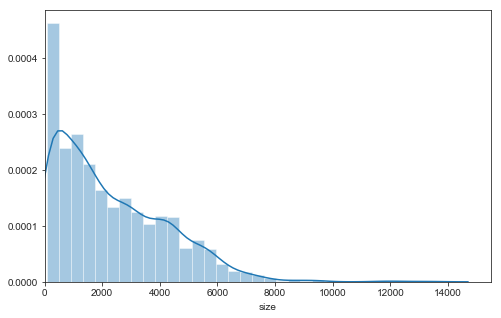

In [20]:
distplot = sns.distplot(A1["size"], axlabel="size")
plt.xlim(0, None)
fig = distplot.get_figure()
fig.savefig("A1-size.png") 

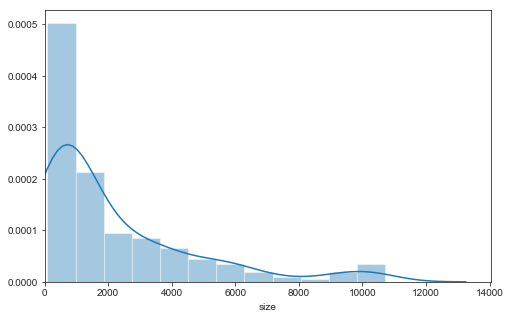

In [21]:
distplot = sns.distplot(A2["size"], axlabel="size")
plt.xlim(0, None)
fig = distplot.get_figure()
fig.savefig("A2-size.png") 

These distributions do not appear to be normal. To verify this, we do a two-tailed t-test, with $H_0$ that the distribution is normal. 

In [22]:
print("A1: ", st.normaltest(A1["size"]))
print("A2: ", st.normaltest(A2["size"]))

A1:  NormaltestResult(statistic=375.31687551872864, pvalue=3.169392300335088e-82)
A2:  NormaltestResult(statistic=79.04635801563494, pvalue=6.843865243277433e-18)


For each, since $p<0.5$, we reject the null hypothesis and conclude that the distribution is not normal.

Moreover, the distributions appear distinct from each other. We test this with the Kolmogorov-Smirnov test. The null hypothesis $H_0$ is that the distributions are the same.

In [23]:
st.ks_2samp(A1["size"], A2["size"])

Ks_2sampResult(statistic=0.15457151492393784, pvalue=8.314559193561194e-05)

Since $p<0.5$, we reject the null hypothesis, and conclude that the distributions are different.

We would like to know what the underlying distribution for each variable is, so we fit a variety of distributions and select the one with minimum sum of squared error (SSE).

In [27]:
matplotlib.style.use('seaborn-notebook')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [st.alpha, st.betaprime, st.burr, st.erlang, st.exponnorm, st.f, 
                     st.fisk, st.frechet_r, st.gamma, st.genextreme, st.gengamma, 
                     st.gilbrat, st.gumbel_r, st.invgamma, st.invgauss, st.invweibull, 
                     st.lognorm, st.mielke, st.ncf, st.pareto, st.recipinvgauss, st.wald]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    sses = {}

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                sses[distribution] = sse

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params, sses)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

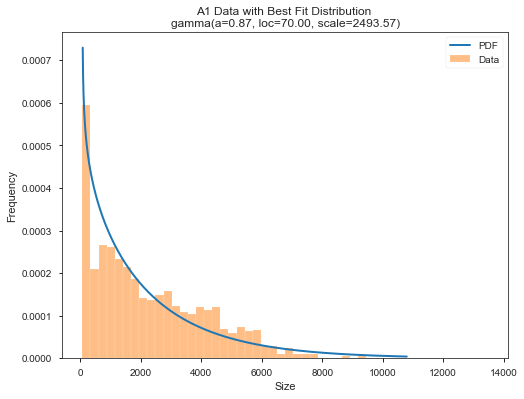

In [28]:
# For A1 "size" data
data = A1["size"]

# Find best fit distribution
best_fit_name, best_fit_params, sses1 = best_fit_distribution(data, 200)#, ax)
best_dist = getattr(st, best_fit_name)

sorted_sses1 = sorted(sses1, key=sses1.get)

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(8,6))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'A1 Data with Best Fit Distribution \n' + dist_str)
ax.set_xlabel(u'Size')
ax.set_ylabel('Frequency')
plt.savefig("A1-bestfit.png")

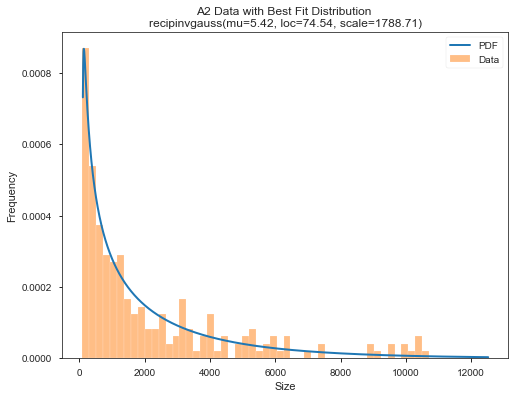

In [29]:
# For A2 "size" data
data = A2["size"]

# Find best fit distribution
best_fit_name, best_fit_params, sses1 = best_fit_distribution(data, 200)#, ax)
best_dist = getattr(st, best_fit_name)

sorted_sses1 = sorted(sses1, key=sses1.get)

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(8,6))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'A2 Data with Best Fit Distribution \n' + dist_str)
ax.set_xlabel(u'Size')
ax.set_ylabel('Frequency')
plt.savefig("A2-bestfit.png")

For the A1 data set, the best fit distribution is the gamma distribution. For the A2 data set, it is the reciprocal inverse Gaussian distribution. 